In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import pandas as pd
import gran

In [22]:
annot_path = gran.get_cache_path('deep_annot', 'annotations.csv')
annot = pd.read_csv(annot_path)

number of articles, provided by yongfu

In [9]:
25+17+12+24

78

In [10]:
78*4

312

In [8]:
len(annot.full_text.unique())

137

In [23]:
annot.shape

(500, 10)

In [31]:
annot.function_coarse[(annot.form==3.2)].value_counts()

sem     170
prag    141
parg      1
Name: function_coarse, dtype: int64

# Index

In [21]:
index_url = "https://yongfu.name/pixnet/"
index_dom = BeautifulSoup(requests.get(index_url).text)

In [22]:
from urllib.parse import urljoin

In [23]:
links = [urljoin(index_url, x["href"]) for x in index_dom.select("a")]

In [24]:
urls = []
for link_x in gran.tqdm(links):
    dom = BeautifulSoup(requests.get(link_x).text)
    blog_urls = [urljoin(link_x, atag.get("href")) for atag in dom.select("a")]
    urls.extend(blog_urls)    

In [25]:
len(urls)

316

# URLs

In [44]:
import requests
from bs4 import BeautifulSoup

In [45]:
# urls = annot.full_text.unique().tolist()

In [46]:
import pickle
gran.install_data_cache("blogs")

In [60]:
page_contents = {}

In [56]:
blog_cache_path = gran.get_cache_path("blogs", "page")
if blog_cache_path.exists():
    with open(blog_cache_path, "rb") as fin:
        page_contents = pickle.load(fin)
else:
    page_contents = {}

In [61]:
def extract_article(url):
    resp = requests.get(url)
    if resp.status_code != 200:
        print(f"[{resp.status_code}]")
        return "" 
    return resp.content
    # dom = BeautifulSoup(resp.text, 'html5lib')
    # try:
    #     article = dom.select_one(".post__left-content, #article-area, .article-content").text
    # except:
    #     print(url)               
    # return article

In [62]:
for url_x in gran.tqdm(urls):
    if url_x in page_contents: continue
    page_contents[url_x] = extract_article(url_x)        

[404]


In [63]:
with open(blog_cache_path, "wb") as fout:
    pickle.dump(page_contents, fout)

# Parse

In [1]:
from bs4 import BeautifulSoup
import pickle
import chardet
import re

In [68]:
chardet.detect(list(page_contents.values())[0])

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}

## Load cache-response

In [9]:
blog_cache_path = gran.get_cache_path("blogs", "page.pkl")
with open(blog_cache_path, "rb") as fin:
    blog_cache = pickle.load(fin)


In [10]:
len(blog_cache)

315

In [11]:
articles = {}
cjk_pat = re.compile("[\u4e00-\u9fff\uFF00-\uFFEF\u3000-\u303F.,!?]{2,}")

In [12]:
for url, content in gran.tqdm(blog_cache.items()):
    if url in articles: 
        # print("existed: " + url)
        continue
        
    try:
        enc_det = chardet.detect(content)
    except Exception as ex:
        print(url)
        continue
        
    if enc_det["confidence"] > 0.5:
        enc = enc_det["encoding"]
    else:
        enc = "utf-8"
    
    try:
        dom = BeautifulSoup(content.decode(enc), 'html5lib')    
        article = dom.select_one(".post__left-content, #article-area, .article-content").text
        articles[url] = "".join(cjk_pat.findall(article))
    except Exception as ex:        
        print(ex)
    

https://s909028.pixnet.net/blog/post/35354038



In [13]:
blog_cache_path = gran.get_cache_path("blogs", "articles.pkl")
with open(blog_cache_path, "wb") as fout:
    pickle.dump(articles, fout)

In [14]:
import matplotlib.pyplot as plt

(array([187., 100.,  15.,   7.,   3.,   0.,   0.,   0.,   0.,   2.]),
 array([   92. ,  1126.7,  2161.4,  3196.1,  4230.8,  5265.5,  6300.2,
         7334.9,  8369.6,  9404.3, 10439. ]),
 <a list of 10 Patch objects>)

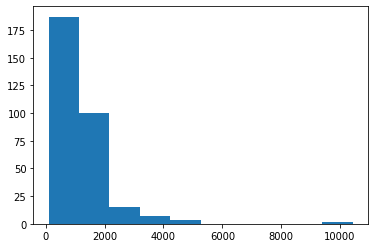

In [15]:
plt.hist([len(x) for x in articles.values()])

In [18]:
[(k, x[:100]) for k, x in articles.items() if len(x) > 1e4]

[('https://olalaa.pixnet.net/blog/post/22970360',
  '台北美食．美食台北台北美食．美食台北歐洲美食................................美國菜.................................花園餐廳......'),
 ('https://tony01254470.pixnet.net/blog/post/21345076',
  '台北美食台北美食．美食台北.歐洲美食................................美國菜.................................花園餐廳..........')]

In [19]:
sum([len(x) for x in articles.values()])

383689